# Kaggle Competition Titanic

In [1]:
# !pip install xgboost

In [91]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
import xgboost as xgb

In [3]:
# Import raw Data
train_data = pd.read_csv("train.csv")
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning

Let's take a look at the raw information. Based on the head view of the dataframe, there seems to be NaN so we will be removing them. We need to see which columns contain the most NaN value and see if its important. 

In [4]:
# Determine number of rows before cleaning
num_data_pre_clean = train_data.shape[0]

# Determine number of rows after cleaning
cleaned_train_data = train_data.dropna()
num_data_post_clean = cleaned_train_data.shape[0]

print("Pre-cleaning", num_data_pre_clean)
print("Post-cleaning", num_data_post_clean)

Pre-cleaning 891
Post-cleaning 183


In [5]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Seems like the Cabin column contains the most NaN values. Let's drop these. 

In [6]:
train_data = train_data.drop(columns=['Cabin'])

In [7]:
# Process the cleaning again 
# Determine number of rows before cleaning
num_data_pre_clean = train_data.shape[0]

# Determine number of rows after cleaning
cleaned_train_data = train_data.dropna()
num_data_post_clean = cleaned_train_data.shape[0]

print("Pre-cleaning", num_data_pre_clean)
print("Post-cleaning", num_data_post_clean)

Pre-cleaning 891
Post-cleaning 712


Change the gender to be binary to make the ML model easier to learn trends

In [8]:
cleaned_train_data['Sex'] = cleaned_train_data['Sex'].replace('male', 0)
cleaned_train_data['Sex'] = cleaned_train_data['Sex'].replace('female', 1)
# cleaned_train_data

C:\Users\Francis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Francis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Change the embark location to be numeric to make the ML model easier to learn trends

In [9]:
cleaned_train_data['Embarked'] = cleaned_train_data['Embarked'].replace('C', 0)
cleaned_train_data['Embarked'] = cleaned_train_data['Embarked'].replace('S', 1)
cleaned_train_data['Embarked'] = cleaned_train_data['Embarked'].replace('Q', 2)
# cleaned_train_data

C:\Users\Francis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Francis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Francis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [10]:
cleaned_train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,1


In [90]:
cleaned_train_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

## Exploratory Analysis

### Dead vs Survived

Let's take a look at how many died and survived. We will then take a look at each factor relative to whether the individual perished in the disaster. 

In [11]:
died = cleaned_train_data[cleaned_train_data['Survived'] == 0]
count_died = died.shape[0]

survived = cleaned_train_data[cleaned_train_data['Survived'] == 1]
count_survived = survived.shape[0]

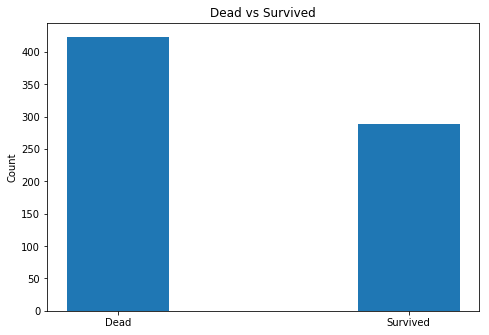

In [12]:
# Plot number of people who died or survived
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
status = ['Dead', 'Survived']
width = 0.35
status_count = [count_died, count_survived]
ax.bar(status,status_count, width)
ax.set_ylabel('Count')
ax.set_title('Dead vs Survived')
plt.show()

### Dead vs Survived by class

In [13]:
# Determine count of people within each Pclass from the died and survived dataframe
dead_pclass_count = []
survived_pclass_count = []
counter = 0;
for i in sorted(set(died['Pclass'].unique())):
    dead_pclass_count.append(died[died['Pclass'] == i].shape[0])

for i in sorted(set(survived['Pclass'].unique())):
    survived_pclass_count.append(survived[survived['Pclass'] == i].shape[0])

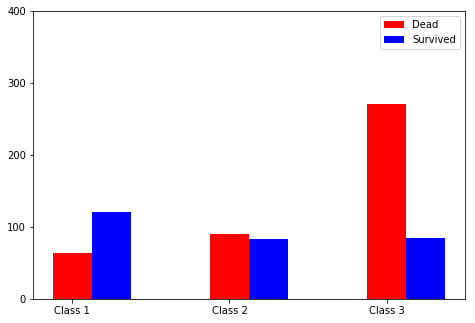

In [14]:
fig = plt.figure()
data = [dead_pclass_count,
survived_pclass_count]
X = np.arange(3)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.set_yticks(np.arange(0,500,100))
plt.xticks(X, ('Class 1', 'Class 2', 'Class 3'))
ax.legend(labels=['Dead', 'Survived'])
plt.show()

Seems like a lot of people from Class 3 died. This is a good indication of a relationship between the output and the class. 

### Dead vs Survived by Gender

In [15]:
# Determine count of people within each Pclass from the died and survived dataframe
dead_sex_count = []
survived_sex_count = []
counter = 0;

for i in sorted(set(died['Sex'].unique())):
    dead_sex_count.append(died[died['Sex'] == i].shape[0])

for i in sorted(set(survived['Sex'].unique())):
    survived_sex_count.append(survived[survived['Sex'] == i].shape[0])

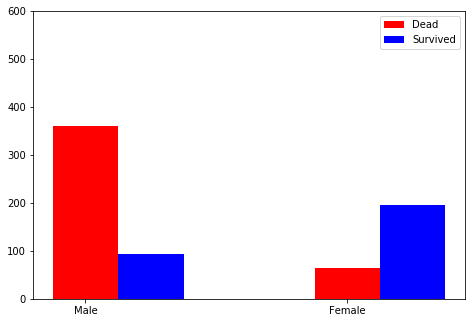

In [16]:
fig = plt.figure()
data = [dead_sex_count,
survived_sex_count]
X = np.arange(2)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.set_yticks(np.arange(0,700,100))
plt.xticks(X, ('Male', 'Female'))
ax.legend(labels=['Dead', 'Survived'])
plt.show()

In [17]:
total_male = dead_sex_count[0] + survived_sex_count[0]
total_female = dead_sex_count[1] + survived_sex_count[1]
print("Male", total_male)
print("Female", total_female)

Male 453
Female 259


In [18]:
# Survival Rate
survival_rate_male = survived_sex_count[0] / total_male
survival_rate_female = survived_sex_count[1] / total_female

print("Male Survival Rate: ", survival_rate_male)
print("Female Survival Rate: ", survival_rate_female)

Male Survival Rate:  0.2052980132450331
Female Survival Rate:  0.752895752895753


More males died than females. This makes sense since they would give priority to females and kids. 

### Dead vs Survived by Age

C:\Users\Francis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Francis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


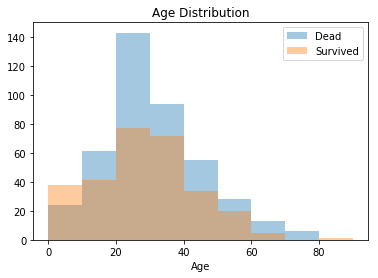

In [19]:
dead_age = died['Age']
survived_age = survived['Age']

fig, ax = plt.subplots()
for age_lists in [dead_age, survived_age]:
    sns.distplot(age_lists, bins = np.arange(0,100,10),kde=False)
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Age Distribution")
plt.show()

### Dead vs Survived with relation to family 

#### Siblings

C:\Users\Francis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Francis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


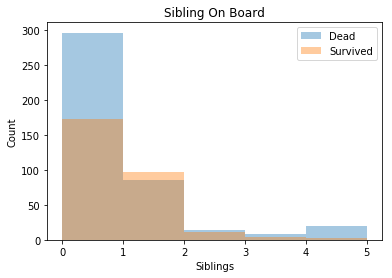

In [20]:
dead_sib_count = died['SibSp']
survived_sib_count = survived['SibSp']

fig, ax = plt.subplots()
for sibling_lists in [dead_sib_count, survived_sib_count]:
    sns.distplot(sibling_lists, bins = np.arange(0, 6, 1),kde=False)
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Sibling On Board")
plt.xlabel("Siblings")
plt.ylabel("Count")
plt.show()

#### Parents

C:\Users\Francis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Francis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


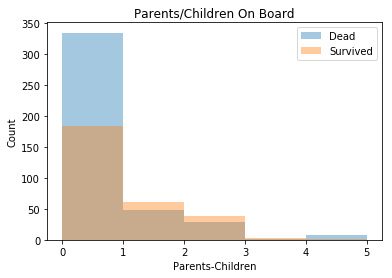

In [21]:
dead_parents_count = died['Parch']
survived_parents_count = survived['Parch']

fig, ax = plt.subplots()
for parents_lists in [dead_parents_count, survived_parents_count]:
    sns.distplot(parents_lists, bins = np.arange(0, 6, 1),kde=False)
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Parents/Children On Board")
plt.xlabel("Parents-Children")
plt.ylabel("Count")
plt.show()

### Dead vs Survived by Fare

In [22]:
dead_fare = died['Fare']
survived_fare = survived['Fare']

expensive_fare = max(cleaned_train_data['Fare'])
average_fare = np.average(cleaned_train_data['Fare'])
print("Most Expensive Ticket", expensive_fare)
print("Average Ticket Price", average_fare)

Most Expensive Ticket 512.3292
Average Ticket Price 34.567251404494385


C:\Users\Francis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Francis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


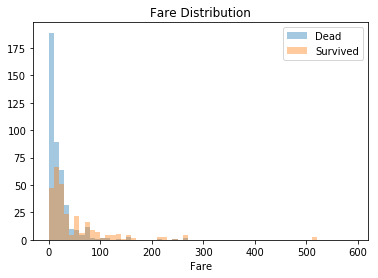

In [23]:
fig, ax = plt.subplots()
for fare_lists in [dead_fare, survived_fare]:
    sns.distplot(fare_lists, bins = np.arange(0,600,10),kde=False)
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Fare Distribution")
plt.show()

### Dead vs Survived by Embark Location

In [24]:
# Determine count of people within each Pclass from the died and survived dataframe
dead_embark_count = []
survived_embark_count = []
counter = 0;

embark_locations = sorted(set(died['Embarked'].unique()))         
print(embark_locations)

for i in embark_locations:
    dead_embark_count.append(died[died['Embarked'] == i].shape[0])

for i in embark_locations:
    survived_embark_count.append(survived[survived['Embarked'] == i].shape[0])

[0, 1, 2]


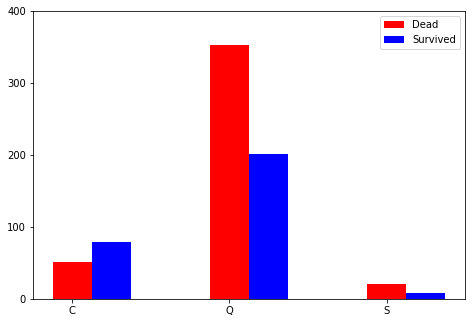

In [25]:
fig = plt.figure()
data = [dead_embark_count,
survived_embark_count]
X = np.arange(3)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.set_yticks(np.arange(0,500,100))
plt.xticks(X, ('C', 'Q', 'S'))
ax.legend(labels=['Dead', 'Survived'])
plt.show()

## Correlation Matrix to determine Feature Importance

In [26]:
cleaned_train_data = cleaned_train_data.drop(columns=["Name", "Ticket"])

In [27]:
corr_data = cleaned_train_data.corr()

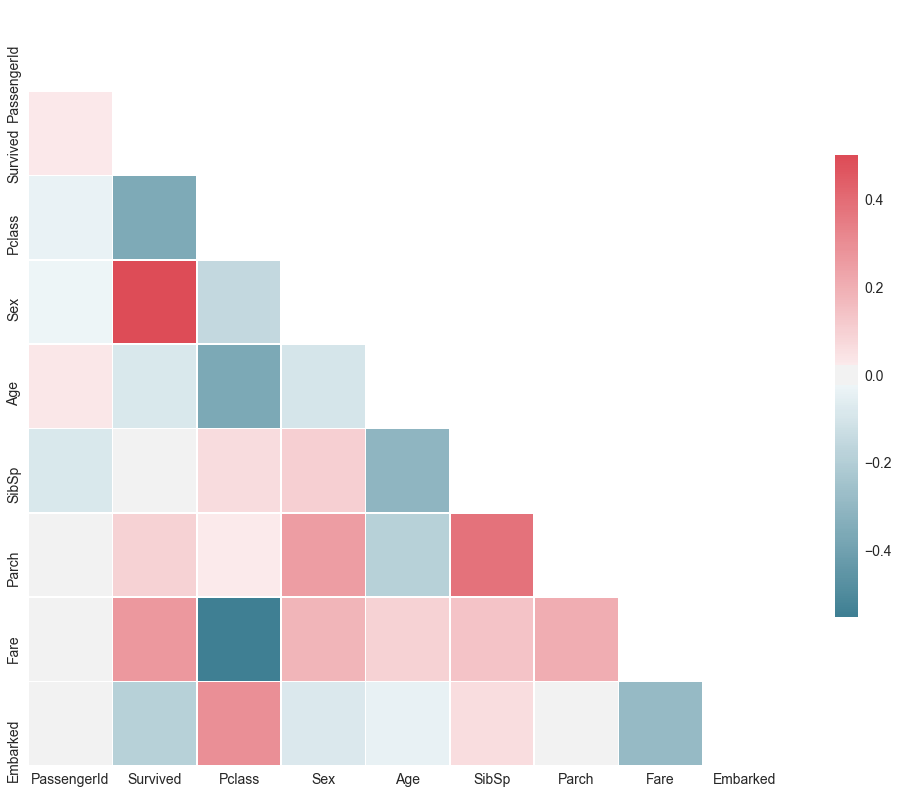

In [28]:
sns.set(style="white", font_scale = 1.4)
mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(17, 17))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_data, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Certain factors seem to heavily influence the odds of an individual dying:
- Age
- Sex 
- Class
- Fare

## Model Implementation

In this section, we will first separate the data into two sets, training and test data. Two classification models will be investigated, which each hyperparameter being tuned. The two models that I looked into are:
- RF Classifier
- XGBoost Classifier

In [29]:
X = cleaned_train_data.drop(columns=["Survived"])
y = cleaned_train_data["Survived"]

In [70]:
X.head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,0,22.0,1,0,7.2500,1
1,2,1,1,38.0,1,0,71.2833,0
2,3,3,1,26.0,0,0,7.9250,1
3,4,1,1,35.0,1,0,53.1000,1
4,5,3,0,35.0,0,0,8.0500,1


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=125)

### Random Forest Classifier

Earlier section is just to play around with the model. The latter section contains tuning parameters of the model. 

In [31]:
start_time = time.time()
model = RandomForestClassifier()
model.fit(X_train,y_train)
print("Training took: %s seconds" % (time.time() - start_time))

Training took: 0.03689002990722656 seconds


In [32]:
predictions = model.predict(X_test)

In [33]:
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))

Accuracy: 78.04%


In [34]:
# Print classification report
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.76      0.91      0.83       126
          1       0.83      0.59      0.69        88

avg / total       0.79      0.78      0.77       214



In [35]:
survival_conf_matrix = confusion_matrix(y_test, predictions)
# print (survival_conf_matrix)
class_names = cleaned_train_data['Survived'].unique()
class_names_label = ['negative', 'positive']

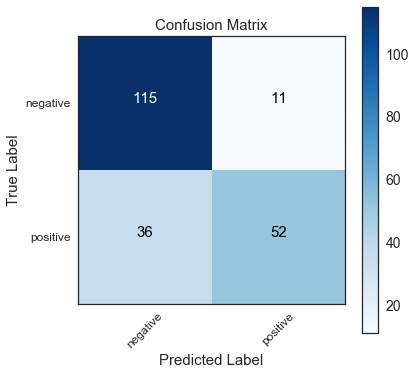

In [36]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(survival_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names_label, rotation=45, fontsize=12)
plt.yticks(tick_marks, class_names_label, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)


for i in range(len(survival_conf_matrix)):
    for j in range(len(survival_conf_matrix[i])):
        color = 'black'   
        if survival_conf_matrix[i][j] > 100:
            color = 'white'
        plt.text(j, i, format(survival_conf_matrix[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

Area under the ROC curve: 0.793493


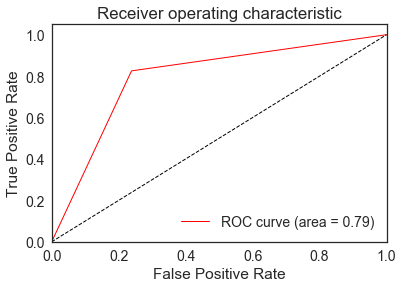

In [37]:
# ROC curve - plot True Positive Rate against False Positive Rate
fpr, tpr, thresholds = roc_curve(predictions, y_test)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [38]:
def run_kfold(X, Y, model):
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = accuracy_score(Y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    var_outcome = np.var(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 
    print("Variance: {0}".format(var_outcome)) 
    
    return {'mean': mean_outcome, 'std': std_outcome, 'var': var_outcome, 'outcomes':outcomes}

In [39]:
def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    return np.mean(np.power((y_predict-y),2))

def variance(y_predict,y):
    y_predict = np.array(y_predict)
    return np.var(y_predict)

In [40]:
# # Tune Random Forest Classifier
model_RF = RandomForestClassifier(random_state = 42)
model_RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
model_RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [42]:
result_model_RF = run_kfold(X_train,y_train, model_RF)

predictions_RF = model_RF.predict(X_test)
Test_Score_RF = accuracy_score(y_test, predictions_RF)

print ("------------------\nTest Score: " + str(Test_Score_RF))

Fold 1 accuracy: 0.8
Fold 2 accuracy: 0.8
Fold 3 accuracy: 0.86
Fold 4 accuracy: 0.74
Fold 5 accuracy: 0.84
Fold 6 accuracy: 0.74
Fold 7 accuracy: 0.74
Fold 8 accuracy: 0.86
Fold 9 accuracy: 0.7959183673469388
Fold 10 accuracy: 0.7142857142857143
Mean r2: 0.7890204081632655
Standard Deviation: 0.050752422731936475
Variance: 0.002575808413161182
------------------
Test Score: 0.7990654205607477


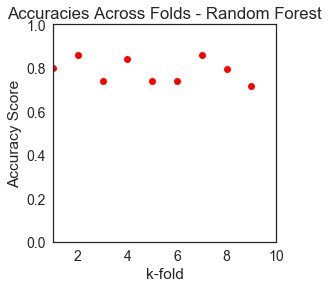

In [43]:
plt.figure(figsize=(4,4))
plt.plot(result_model_RF['outcomes'], 'ro')
plt.axis([1, 10, 0, 1])
plt.ylabel('Accuracy Score')
plt.xlabel('k-fold')
plt.title('Accuracies Across Folds - Random Forest')
plt.show()

In [44]:
# Bias variance trade off
max_depth_RF_classifier = np.arange(2,50)
accuracy_RF_list = []
bias_RF_list = []
var_RF_list = []
total_RF_list = []
err_RF_classification_test = []
err_RF_classification_training = []
err_tot_RF_classification_list = []
score_RF_classification_test = []
score_RF_classification_training = []
score_RF_accuracy_score = []

model_RF = RandomForestClassifier(random_state = 42)

for entry in max_depth_RF_classifier:
    model_RF.set_params(max_depth=entry)
    model_RF.fit(X_train, y_train)
    predicted_y_RF_classifier_test = model_RF.predict(X_test)
    predicted_y_RF_classifier_train = model_RF.predict(X_train)
    
    # Bias and variance estimate
    bias_variable = bias(predicted_y_RF_classifier_test, y_test)
    variance_variable = variance(predicted_y_RF_classifier_test, y_test)
    
    bias_RF_list.append(bias_variable)
    var_RF_list.append(variance_variable)
    
    total_RF_classification = bias_variable + variance_variable
    total_RF_list.append(total_RF_classification)
    
    # Training and test estimate
    err_RF_variable_test = mean_squared_error(y_test, predicted_y_RF_classifier_test)
    err_RF_variable_train = mean_squared_error(y_train, predicted_y_RF_classifier_train)
    err_RF_tot = err_RF_variable_test + err_RF_variable_train
    err_RF_classification_test.append(err_RF_variable_test)
    err_RF_classification_training.append(err_RF_variable_train)
    err_tot_RF_classification_list.append(err_RF_tot)

    # Score
    predictions_test = model_RF.predict(X_test)
    predictions_training = model_RF.predict(X_train)
    
    score_RF_classification_test.append(accuracy_score(y_test, predictions_test))
    score_RF_classification_training.append(accuracy_score(y_train, predictions_training))


In [45]:
max_depth_RF_classifier

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

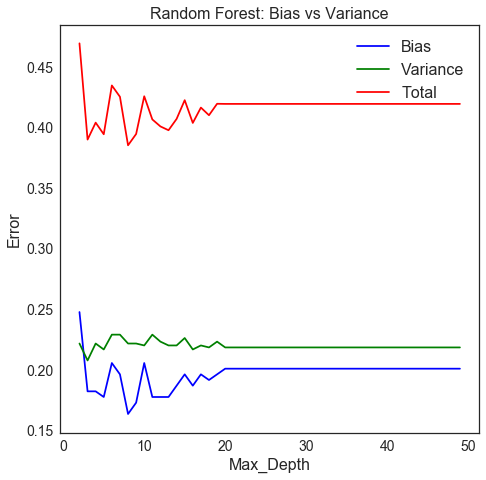

In [46]:
# Plot bias vs variance from changing the depth of the tree
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classifier, bias_RF_list,color = 'b')
plt.plot(max_depth_RF_classifier, var_RF_list,color = 'g')
plt.plot(max_depth_RF_classifier, total_RF_list,color = 'r')
plt.legend(['Bias', 'Variance', 'Total'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Bias vs Variance',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
# plt.ylim(4000, 15000)
plt.show()

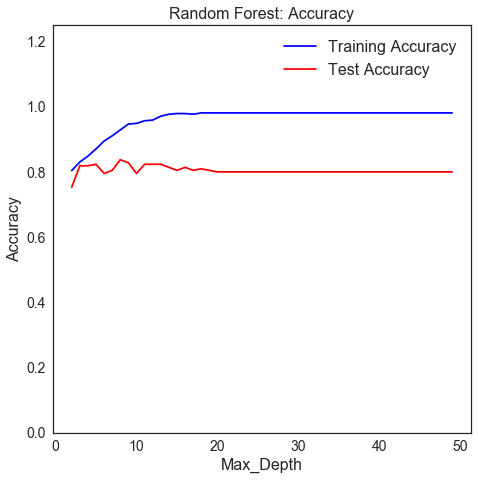

In [47]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classifier, score_RF_classification_training,color = 'b')
plt.plot(max_depth_RF_classifier, score_RF_classification_test,color = 'r')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Accuracy',fontsize = 16)
plt.ylabel('Accuracy',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
plt.ylim(0,1.25)
plt.show()

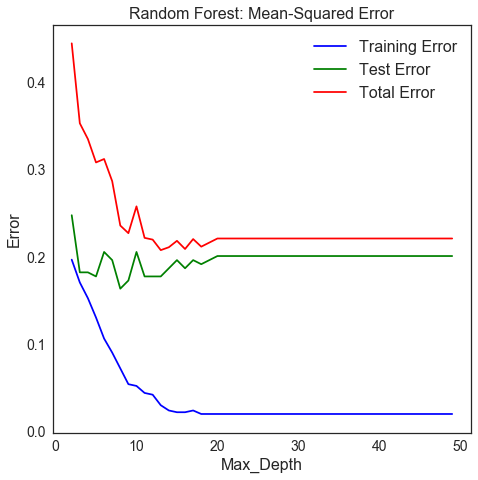

In [48]:

plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classifier, err_RF_classification_training,color = 'b')
plt.plot(max_depth_RF_classifier, err_RF_classification_test,color = 'g')
plt.plot(max_depth_RF_classifier, err_tot_RF_classification_list,color = 'r')
plt.legend(['Training Error', 'Test Error', 'Total Error'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Mean-Squared Error',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
#plt.ylim(0,0.01)
plt.show()

In [49]:
print("Depth\t Score")
for depth, score in zip(max_depth_RF_classifier, err_tot_RF_classification_list):
    print(depth, score)
    if depth == 13:
        break

Depth	 Score
2 0.44445069999624665
3 0.35292572157790036
4 0.33485343242127386
5 0.30809218181135756
6 0.312033179446759
7 0.28662312802612316
8 0.23584055849566488
9 0.22711406373156176
10 0.2578163119768795
11 0.22174680028525315
12 0.2197387681567391
13 0.20769057538565477


Based on the MSE, the optimal depth for the forest would be the parameter that yields min error, which is seen approximately around 13 depth. As the depth becomes greater, the training error is close to zero and remains constant, indicating that the model might be overfitting. 

### Hyperparameter turning of RF Classifier

In [50]:
# Let's use gridsearchCV to do hyperparameter tuning

In [51]:
RF_param = { 
        "n_estimators" : [10, 20, 40, 80, 100],
        "min_samples_leaf": [1, 2, 4, 8, 10],
        "max_depth": [10, 13, 20, 40, 50, None],
        "max_features" : ["auto", "sqrt", "log2"],
        }

cv_model_RF = GridSearchCV(model_RF, cv = 5, param_grid = RF_param, n_jobs=-1, verbose=0)
cv_model_RF.fit(X_train, y_train)

print('Optimal parameters found: ')
print(cv_model_RF.best_params_)
print(cv_model_RF.best_estimator_)

optimal_RF = cv_model_RF.best_estimator_

result_model_RF_tuned = run_kfold(X_train, y_train, optimal_RF)
predictions_RF_tuned = optimal_RF.predict(X_test)
Test_Score_RF_tuned = accuracy_score(y_test, predictions_RF_tuned)

print("Test Score: ")
print(Test_Score_RF_tuned)

Optimal parameters found: 
{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 40}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Fold 1 accuracy: 0.8
Fold 2 accuracy: 0.9
Fold 3 accuracy: 0.84
Fold 4 accuracy: 0.78
Fold 5 accuracy: 0.86
Fold 6 accuracy: 0.72
Fold 7 accuracy: 0.82
Fold 8 accuracy: 0.86
Fold 9 accuracy: 0.7959183673469388
Fold 10 accuracy: 0.7142857142857143
Mean r2: 0.8090204081632653
Standard Deviation: 0.05705253795082713
Variance: 0.0032549920866305703
Test Score: 
0.8177570093457944


## XGBoost Classifier

In [92]:
D_train = xgb.DMatrix(X_train, y_train)
D_test = xgb.DMatrix(X_test, y_test)

In [103]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

In [104]:
model = xgb.train(param, D_train, steps)

In [108]:
preds = model.predict(D_test)
best_preds_xgb = np.asarray([np.argmax(line) for line in preds])

In [109]:
print('Accuracy: %.2f%%' % (accuracy_score(y_test, best_preds_xgb)*100))

Accuracy: 81.78%


In [110]:
print(classification_report(y_test,best_preds_xgb))

             precision    recall  f1-score   support

          0       0.80      0.91      0.86       126
          1       0.85      0.68      0.75        88

avg / total       0.82      0.82      0.81       214



In [111]:
survival_conf_matrix_xgb = confusion_matrix(y_test, best_preds_xgb)
#print (survival_conf_matrix_xgb)
class_names = cleaned_train_data['Survived'].unique()
class_names_label = ['negative', 'positive']

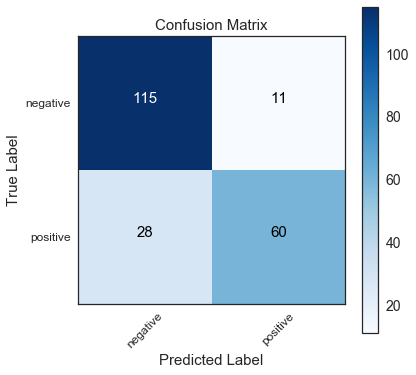

In [112]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(survival_conf_matrix_xgb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names_label, rotation=45, fontsize=12)
plt.yticks(tick_marks, class_names_label, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)


for i in range(len(survival_conf_matrix_xgb)):
    for j in range(len(survival_conf_matrix_xgb[i])):
        color = 'black'   
        if survival_conf_matrix_xgb[i][j] > 100:
            color = 'white'
        plt.text(j, i, format(survival_conf_matrix_xgb[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

Area under the ROC curve: 0.824633


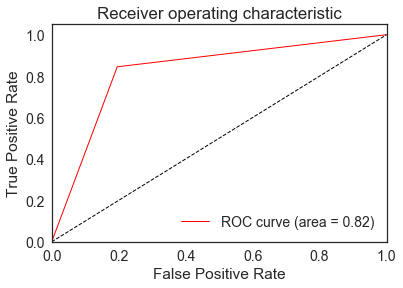

In [113]:
# ROC curve - plot True Positive Rate against False Positive Rate
fpr, tpr, thresholds = roc_curve(best_preds_xgb, y_test)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [84]:
X_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
745,746,1,0,70.0,1,1,71.0000,1
545,546,1,0,64.0,0,0,26.0000,1
704,705,3,0,26.0,1,0,7.8542,1
779,780,1,1,43.0,0,1,211.3375,1
268,269,1,1,58.0,0,1,153.4625,1


In [114]:
def run_kfold_xgb(X, Y, model):
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = accuracy_score(Y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    var_outcome = np.var(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 
    print("Variance: {0}".format(var_outcome)) 
    
    return {'mean': mean_outcome, 'std': std_outcome, 'var': var_outcome, 'outcomes':outcomes}

In [85]:
result_model_XGB = run_kfold(X_train,y_train, model_XGB)

predictions_XGB = model_XGB.predict(X_test)
Test_Score_XGB= accuracy_score(y_test, predictions_XGB)

print ("------------------\nTest Score: " + str(Test_Score_XGB))

C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 1 accuracy: 0.68
Fold 2 accuracy: 0.82


C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 3 accuracy: 0.84
Fold 4 accuracy: 0.8


C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 5 accuracy: 0.78
Fold 6 accuracy: 0.68


C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 7 accuracy: 0.78
Fold 8 accuracy: 0.84
Fold 9 accuracy: 0.7755102040816326
Fold 10 accuracy: 0.6122448979591837
Mean r2: 0.7607755102040816
Standard Deviation: 0.0732571651437452
Variance: 0.005366612244897956


C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Francis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'] ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
expected f7, f5, f1, f2, f0, f4, f6, f3 in input data
training data did not have the following fields: Parch, SibSp, Fare, Pclass, Embarked, Age, Sex, PassengerId

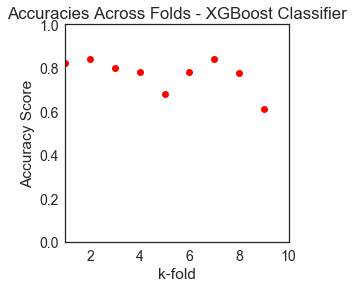

In [66]:
XGB_param = { 
        "n_estimators" : [10, 20, 40, 80, 100],
        "max_depth": [10, 13, 20, 40, 50, None],
        
        }

cv_model_XGB = GridSearchCV(model_RF, cv = 5, param_grid = RF_param, n_jobs=-1, verbose=0)
cv_model_XGB.fit(X_train, y_train)

print('Optimal parameters found: ')
print(cv_model_XGB.best_params_)
print(cv_model_XGB.best_estimator_)

optimal_XGB = cv_model_XGB.best_estimator_

result_model_XGB_tuned = run_kfold(X_train, y_train, optimal_XGB)
predictions_XGB_tuned = optimal_XGB.predict(X_test)
Test_Score_XGB_tuned = accuracy_score(y_test, predictions_XGB_tuned)

print("Test Score: ")
print(Test_Score_XGB_tuned)